In [181]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, skew
from textwrap import fill

In [215]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


In [216]:
dados = gpd.read_file('data/generate/WGS84_hex_sp_agg_2022.gpkg')

In [217]:
dados.head()

,id_hex,Households connected to water supply network (%),Households connected to sewerage system (%),Households solid waste collection (%),qnt_unidades_residencias_sum,qnt_unidades_residencias_mean,qnt_unidades_residencias_median,qnt_unidades_residencias_std,qnt_unidades_residencias_var,Number of private residences,is_fcu,prop_ocupado,railway_intersection,highway_intersection,power_intersection,aeroway_intersection,natural_intersection,waterway_intersection,DCL_count,DCL_sum,Average slope,DCL_median,DCL_stdev,area_sum,Average building area,area_median,Standard deviation of building area,area_var,Number of buildings areas,area_hex,area_const,geometry
0,8aa8100c3257fff,1.000000,1.000000,1.000000,111.0,2.084064,0.000000,4.482464,20.092484,114.0,False,0.0,False,False,False,False,False,False,17.0,114.763455,6.750791,7.233152,2.477970,9316.314802,147.878013,90.353599,156.286531,24425.479717,63.0,18002.590726,0.517499,"POLYGON ((-46.63592 -23.53032, -46.63664 -23.5..."
1,8aa8100d2447fff,1.000000,1.000000,0.991071,108.0,1.374140,0.793144,6.736500,45.380426,157.0,False,0.0,False,False,False,False,False,False,17.0,183.400695,10.788276,11.354718,2.920822,8329.150087,80.865535,61.867680,70.215211,4930.175810,103.0,18009.360752,0.462490,"POLYGON ((-46.53650 -23.53972, -46.53722 -23.5..."
2,8aa8100e1637fff,1.000000,0.976744,0.976744,95.0,5.270948,0.000035,14.440480,208.527469,70.0,False,0.0,False,False,False,False,False,False,19.0,145.991197,7.683747,7.806656,1.598158,2348.146472,90.313326,71.872491,74.175720,5502.037442,26.0,17997.005022,0.130474,"POLYGON ((-46.66886 -23.59437, -46.66958 -23.5..."
3,8aa8100f0827fff,0.997512,0.957711,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,471.0,True,1.0,False,False,False,False,False,False,19.0,120.467196,6.340379,5.678412,2.473660,10516.949009,60.442236,46.407855,54.715864,2993.825762,174.0,18001.760632,0.584218,"POLYGON ((-46.59115 -23.61353, -46.59187 -23.6..."
4,8aa81077552ffff,1.000000,0.896552,1.000000,17.0,0.461107,0.066515,0.586045,0.343448,20.0,False,0.0,False,False,False,False,True,False,18.0,89.057189,4.947622,4.948958,1.824722,8476.202920,180.344743,90.848776,224.256436,50290.949080,47.0,18008.574657,0.470676,"POLYGON ((-46.59688 -23.46650, -46.59760 -23.4..."


In [218]:
variables = { 
    #"qnt_unidades_residencias_sum": "Soma de Residências com Unidades de IPTU", # regularidade fundiária dos
    "Number of private residences": "Quantidade de Residenciais CNEFE 2022", # regularidade fundiária dos
    "Average building area": "Média da área de construção (Open Buildings)", # ambiente construído
    "Standard deviation of building area": "Desvio Padrão Soma da área de construção (Open Buildings)", #ambiente construído
    "Number of buildings areas": "Quantidade de construção (Open Buildings)", #ambiente construído
    "Households connected to water supply network (%)": "Porcentagem dos domicílios com acesso à rede de água da rede geral ", #infraestrutura urbana
    "Households connected to sewerage system (%)": "Porcentagem dos domicílios com acesso à rede de esgoto geral", #infraestrutura urbana
    "Households solid waste collection (%)": "Porcentagem dos domicílios com lixo coletado", #infraestrutura urbana
    #"D1_044_p": "Porcentagem dos domicílios com energia elétrica de companhia distribuidora", #infraestrutura urbana
    "Average slope": "Declividade média do terreno em km"
    
}
binary_var = ['railway_intersection',	'highway_intersection', 'power_intersection', 'aeroway_intersection',	'natural_intersection', 'waterway_intersection'	]

In [186]:
variables_groups = {
    "regularidade fundiária": ["qnt_unidades_residencias_sum", "esp_1"],
    "ambiente construído": ["area_mean", "area_std", "area_count"],
    "infraestrutura urbana": ['domicilios_agua_rede_geral_porcentage', 'domicilios_esgoto_rede_geral_porcentage', 'domicilios_lixo_coletado_porcentage'],
    "topografia": ["DCL_mean"]
}

In [219]:
dados[['is_fcu']] = dados[['is_fcu']].astype(int)
dados[binary_var] = dados[binary_var].astype(int)

In [220]:
df = dados[list(variables.keys()) + ['is_fcu']]

In [221]:
df.describe()

,Number of private residences,Average building area,Standard deviation of building area,Number of buildings areas,Households connected to water supply network (%),Households connected to sewerage system (%),Households solid waste collection (%),Average slope,is_fcu
count,54855.000000,54855.000000,54855.000000,54855.000000,54855.000000,54855.000000,54855.000000,54855.000000,54855.000000
mean,90.699663,100.329009,117.788163,82.227181,0.975446,0.916500,0.993190,8.951999,0.065828
std,86.787212,85.189891,162.429684,47.074763,0.123650,0.202833,0.052606,6.898480,0.247984
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,67.533921,57.741891,43.000000,1.000000,0.959230,1.000000,3.437699,0.000000
50%,73.000000,82.247154,79.579550,81.000000,1.000000,1.000000,1.000000,8.840641,0.000000
75%,120.000000,108.572281,122.338772,118.000000,1.000000,1.000000,1.000000,13.235503,0.000000
max,1601.000000,6933.180301,5936.943871,260.000000,1.000000,1.000000,1.000000,58.659430,1.000000


In [223]:
# Analisando nulos
columns_nulos = ['Number of private residences']

In [224]:
# Analisando nulos

condition = (df[columns_nulos].isnull() | df[columns_nulos] == 0).sum(axis=1) >= len(df[columns_nulos].columns)
df_filtered = df[~condition]


In [225]:
dados_f = dados.loc[df_filtered.index]

In [226]:
counts = condition.value_counts()
percentages = (counts / len(df)) * 100

if True in counts and True in percentages:
    print(f'Quantidade de registros com nulos: {counts[True]} ({percentages[True]:.2f}%)')
else:
    print('Nenhum registro com nulos encontrado.')


Nenhum registro com nulos encontrado.


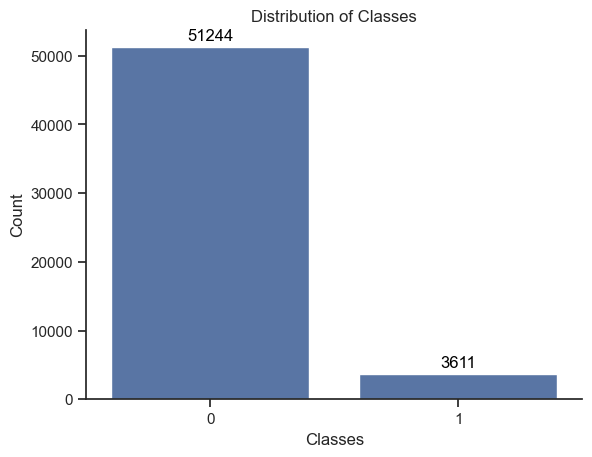

In [227]:
# Plot using Seaborn

ax = sns.countplot(data=df_filtered, x='is_fcu')



for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [228]:
print(f"Orginal {df.shape}, Filtred {df_filtered.shape}")


Orginal (54855, 9), Filtred (54855, 9)


In [229]:
df_filtered[df_filtered['is_fcu'] == 1][variables.keys()].describe()

,Number of private residences,Average building area,Standard deviation of building area,Number of buildings areas,Households connected to water supply network (%),Households connected to sewerage system (%),Households solid waste collection (%),Average slope
count,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000
mean,133.900858,61.809452,55.053429,119.117696,0.930346,0.692065,0.979621,10.845157
std,99.095559,16.949186,39.712612,51.858531,0.178629,0.315190,0.071761,9.886195
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,51.701068,39.063566,80.000000,0.972222,0.467789,0.986667,0.000000
50%,120.000000,59.187131,47.014923,122.000000,1.000000,0.822222,1.000000,11.129909
75%,185.000000,68.645797,59.425297,158.000000,1.000000,0.961538,1.000000,17.366526
max,962.000000,403.998424,1164.829683,260.000000,1.000000,1.000000,1.000000,52.850592


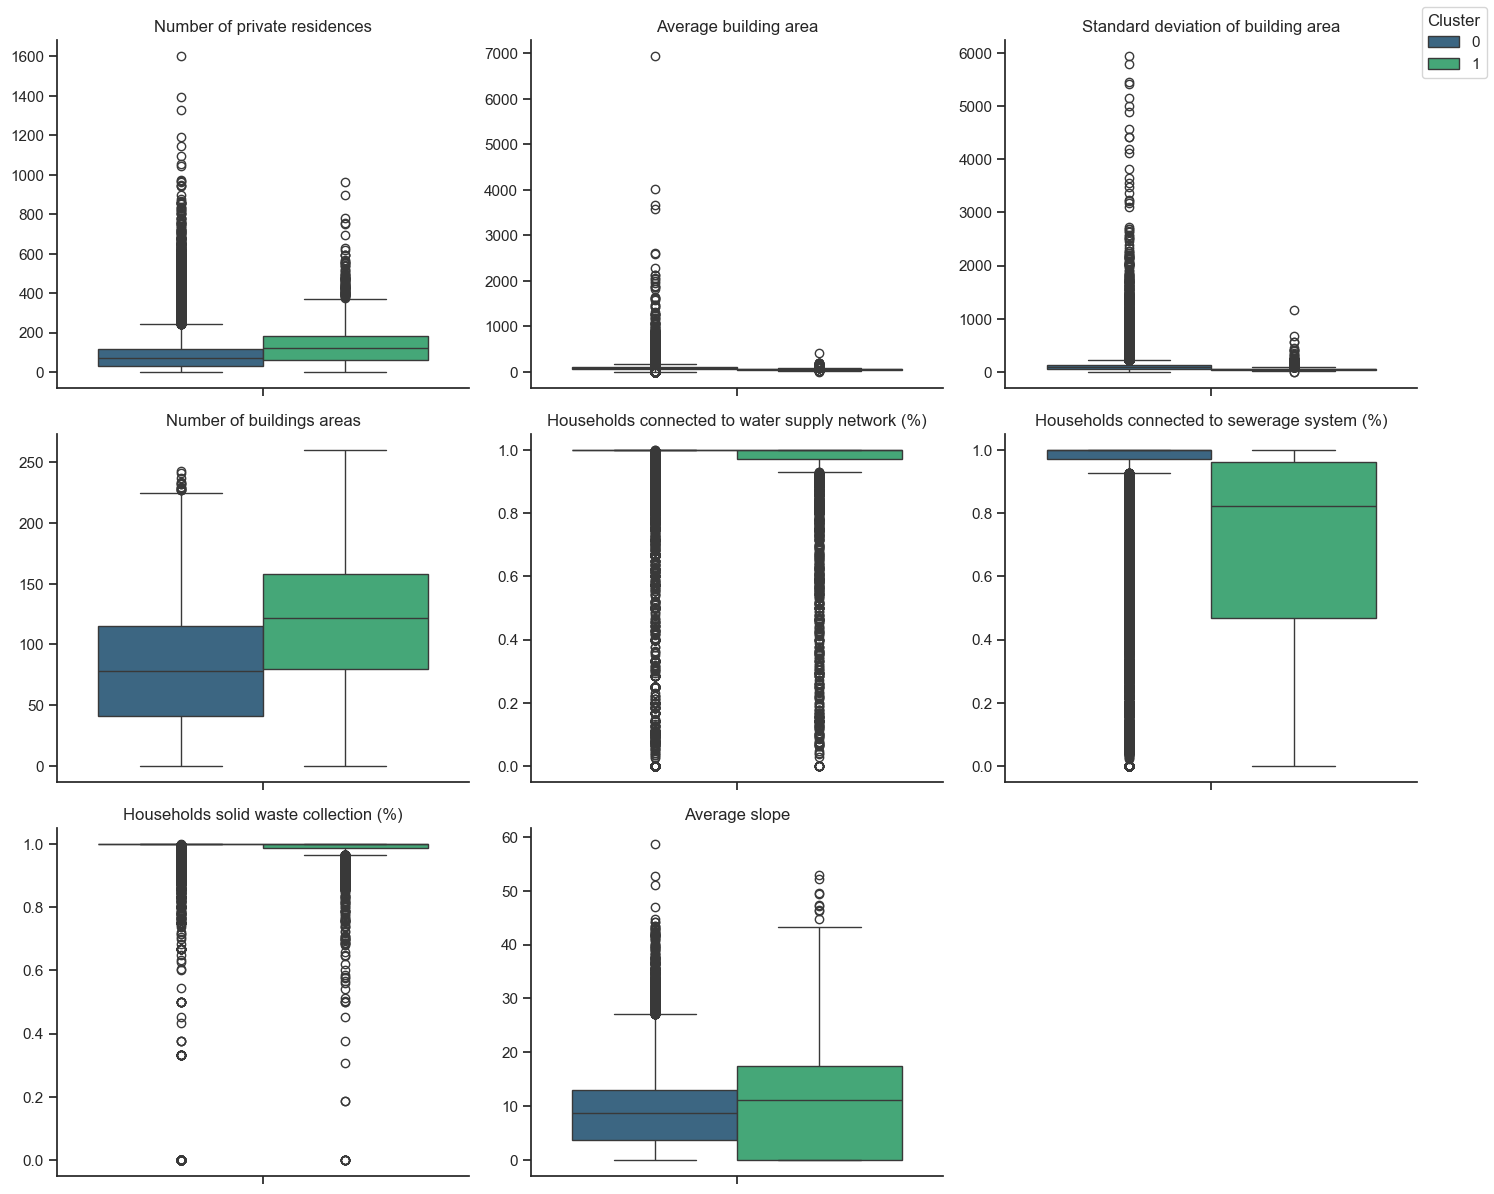

In [233]:
def analyze_variable_distribution(df):

    n_vars = len(variables.keys())
    n_cols = 3  # You can adjust this number to change the number of columns
    n_rows = int(np.ceil(n_vars / n_cols))

    # Creating subplots for each variable
    fig = plt.figure(figsize=(5*n_cols, 4*n_rows))

 
    for i, col in enumerate(variables.keys(), 1):
        ax = fig.add_subplot(n_rows, n_cols, i)
        sns.boxplot(data=df, y=col, hue='is_fcu', ax=ax, palette='viridis')
        ax.set_title(f'{col}')
        ax.set_xlabel('')  # Remove x label as it's redundant
        ax.set_ylabel('')  # Remove x label as it's redundant

        
        # Remove individual legends
        if ax.get_legend() is not None:
            ax.get_legend().remove()


    # Add a single legend to the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title='Cluster')
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Adjust the layout to make room for the legend
    plt.subplots_adjust(right=0.95)
    
    plt.show()

analyze_variable_distribution(df_filtered)

In [234]:
def filter_outliers(df):
    df_filtered_outliers = df.copy()
    for col in df.columns:
        if col != 'is_fcu':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df_filtered_outliers = df_filtered_outliers[(df_filtered_outliers[col] >= lower_bound) & (df_filtered_outliers[col] <= upper_bound)]
    return df_filtered_outliers

In [235]:
# To filter the outliers of the dataset, we need first divide the base in is_fcu = 0 and is_fcu = 1
df_filtered_0 = df_filtered[df_filtered['is_fcu'] == 0]
df_filtered_1 = df_filtered[df_filtered['is_fcu'] == 1]

# Now we filter the outliers using the IQR method
df_filtered_0_no_outliers = filter_outliers(df_filtered_0)
df_filtered_1_no_outliers = filter_outliers(df_filtered_1)

# Concatenating the filtered dataframes
df_filtered_no_outliers = pd.concat([df_filtered_0_no_outliers, df_filtered_1_no_outliers])




In [236]:

print(f"Original shape: {df_filtered.shape}, Shape after removing outliers: {df_filtered_no_outliers.shape}")

Original shape: (54855, 9), Shape after removing outliers: (32207, 9)


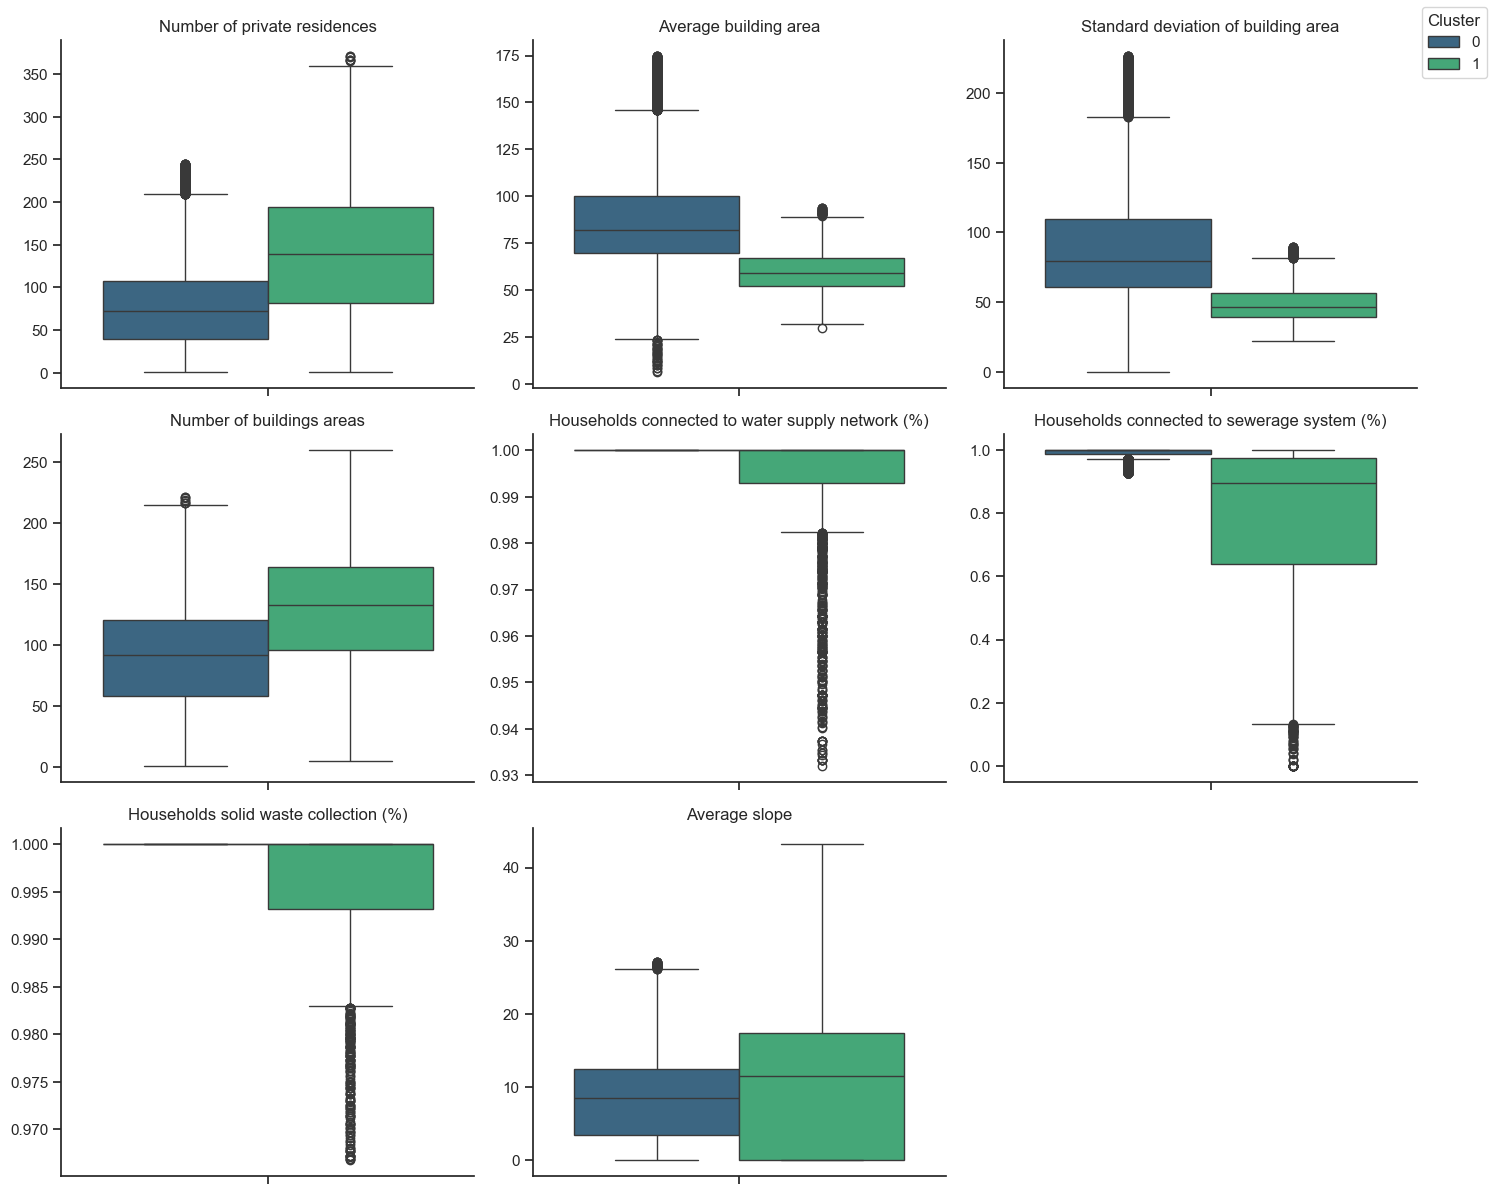

In [237]:
analyze_variable_distribution(df_filtered_no_outliers)

In [238]:
# Group by 'is_fcu' and describe each group
description = df_filtered_no_outliers.groupby('is_fcu').describe()

# Transpose the description for better readability
description_transposed = description.transpose()

# Set pandas display options to show more rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the transposed description
description_transposed

is_fcu                                                             0  \
Number of private residences                     count  29791.000000   
                                                 mean      77.619415   
                                                 std       50.574360   
                                                 min        1.000000   
                                                 25%       39.000000   
                                                 50%       72.000000   
                                                 75%      107.000000   
                                                 max      245.000000   
Average building area                            count  29791.000000   
                                                 mean      87.460877   
                                                 std       25.154311   
                                                 min        6.402784   
                                                 25%       69.511524   
                                                 50%       81.864056   
                                                 75%      100.068044   
                                                 max      174.631463   
Standard deviation of building area              count  29791.000000   
                                                 mean      89.869809   
                                                 std       39.665216   
                                                 min        0.000000   
                                                 25%       60.788467   
                                                 50%       79.181247   
                                                 75%      109.714935   
                                                 max      226.404125   
Number of buildings areas                        count  29791.000000   
                                                 mean      90.254741   
                                                 std       41.538042   
                                                 min        1.000000   
                                                 25%       58.000000   
                                                 50%       92.000000   
                                                 75%      121.000000   
                                                 max      222.000000   
Households connected to water supply network (%) count  29791.000000   
                                                 mean       1.000000   
                                                 std        0.000000   
                                                 min        1.000000   
                                                 25%        1.000000   
                                                 50%        1.000000   
                                                 75%        1.000000   
                                                 max        1.000000   
Households connected to sewerage system (%)      count  29791.000000   
                                                 mean       0.992431   
                                                 std        0.014784   
                                                 min        0.926471   
                                                 25%        0.989362   
                                                 50%        1.000000   
                                                 75%        1.000000   
                                                 max        1.000000   
Households solid waste collection (%)            count  29791.000000   
                                                 mean       1.000000   
                                                 std        0.000000   
                                                 min        1.000000   
                                                 25%        1.000000   
                                                 50%        1.000000   
                                        

## Olhar as distribuições das variaiveis

In [239]:
# Função para calcular o número de outliers
def count_outliers(series):
    Q1 = series.quantile(0.25)  # Primeiro quartil
    Q3 = series.quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1  # Intervalo interquartil
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Contar os outliers
    outliers = ((series < lower_bound) | (series > upper_bound)).sum()
    return outliers

# Função para plotar o gridplot de boxplots com contagem de outliers
def plot_boxplots_with_outliers(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Selecionar apenas colunas numéricas
    n_cols = 3  # Definir o número de colunas no grid
    n_rows = int(np.ceil(len(num_cols) / n_cols))  # Definir o número de linhas com base no número de colunas
    
    # Criar o gridplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()  # Flatten a matriz de eixos para acessar individualmente
    
    for i, col in enumerate(num_cols):
        sns.boxplot(x=df[col], ax=axes[i])  # Gerar boxplot
        title = fill(f'Boxplot de {col}', width=40)
        axes[i].set_title(title)
        
        # Calcular o número de outliers
        outliers_count = count_outliers(df[col].dropna())
        
        # Adicionar o número de outliers ao label
        axes[i].set_xlabel(f'Outliers: {outliers_count} ({outliers_count/df[col].shape[0] * 100}%)')

    # Remover gráficos em branco, se houver
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    # Ajustar layout
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.tight_layout()
    plt.show()

In [248]:
# Função para plotar o gridplot de histogramas e testar a normalidade e skewness
def plot_distributions_and_tests(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Selecionar apenas colunas numéricas
    n_cols = 3  # Definir o número de colunas no grid
    n_rows = int(np.ceil(len(num_cols) / n_cols))  # Definir o número de linhas com base no número de colunas
    
    # Criar o gridplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()  # Flatten a matriz de eixos para acessar individualmente
    fig.suptitle('Variables Distribution', fontsize=16, weight='bold', y=1.02)

    for i, col in enumerate(num_cols):
        sns.kdeplot(df[col], ax=axes[i], fill=True, color='#5ec962') # Gerar histograma com KDE (Kernel Density Estimate)
        title = fill(f'Distribution of {col}', width=40)
        axes[i].set_title(title)
        

        # Teste de normalidade Shapiro-Wilk
        stat, p_value = shapiro(df[col].dropna())  # Descartar valores nulos
        normality = "Normal" if p_value > 0.05 else "Not Normal"
        
        # Cálculo de skewness
        skewness_val = skew(df[col].dropna())
        skewness_type = "Positive" if skewness_val > 0 else "Negative"
        
        # Mostrar resultados no título do plot
        axes[i].set_xlabel(f'Skewness: {skewness_val:.2f} ({skewness_type}) \n Shapiro: p={p_value:.3f} ({normality})')
        #axes[i].set_xlabel(f'Skewness: {skewness_val:.2f} ({skewness_type})')


    # Remover gráficos em branco, se houver
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])


    plt.subplots_adjust(hspace=0.5, wspace=0.3, top=1.5)

    # Ajustar layout
    plt.tight_layout()
    plt.show()


/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54855.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54855.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54855.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 54855.
  res = hypotest_fun_out(*samples, **kw

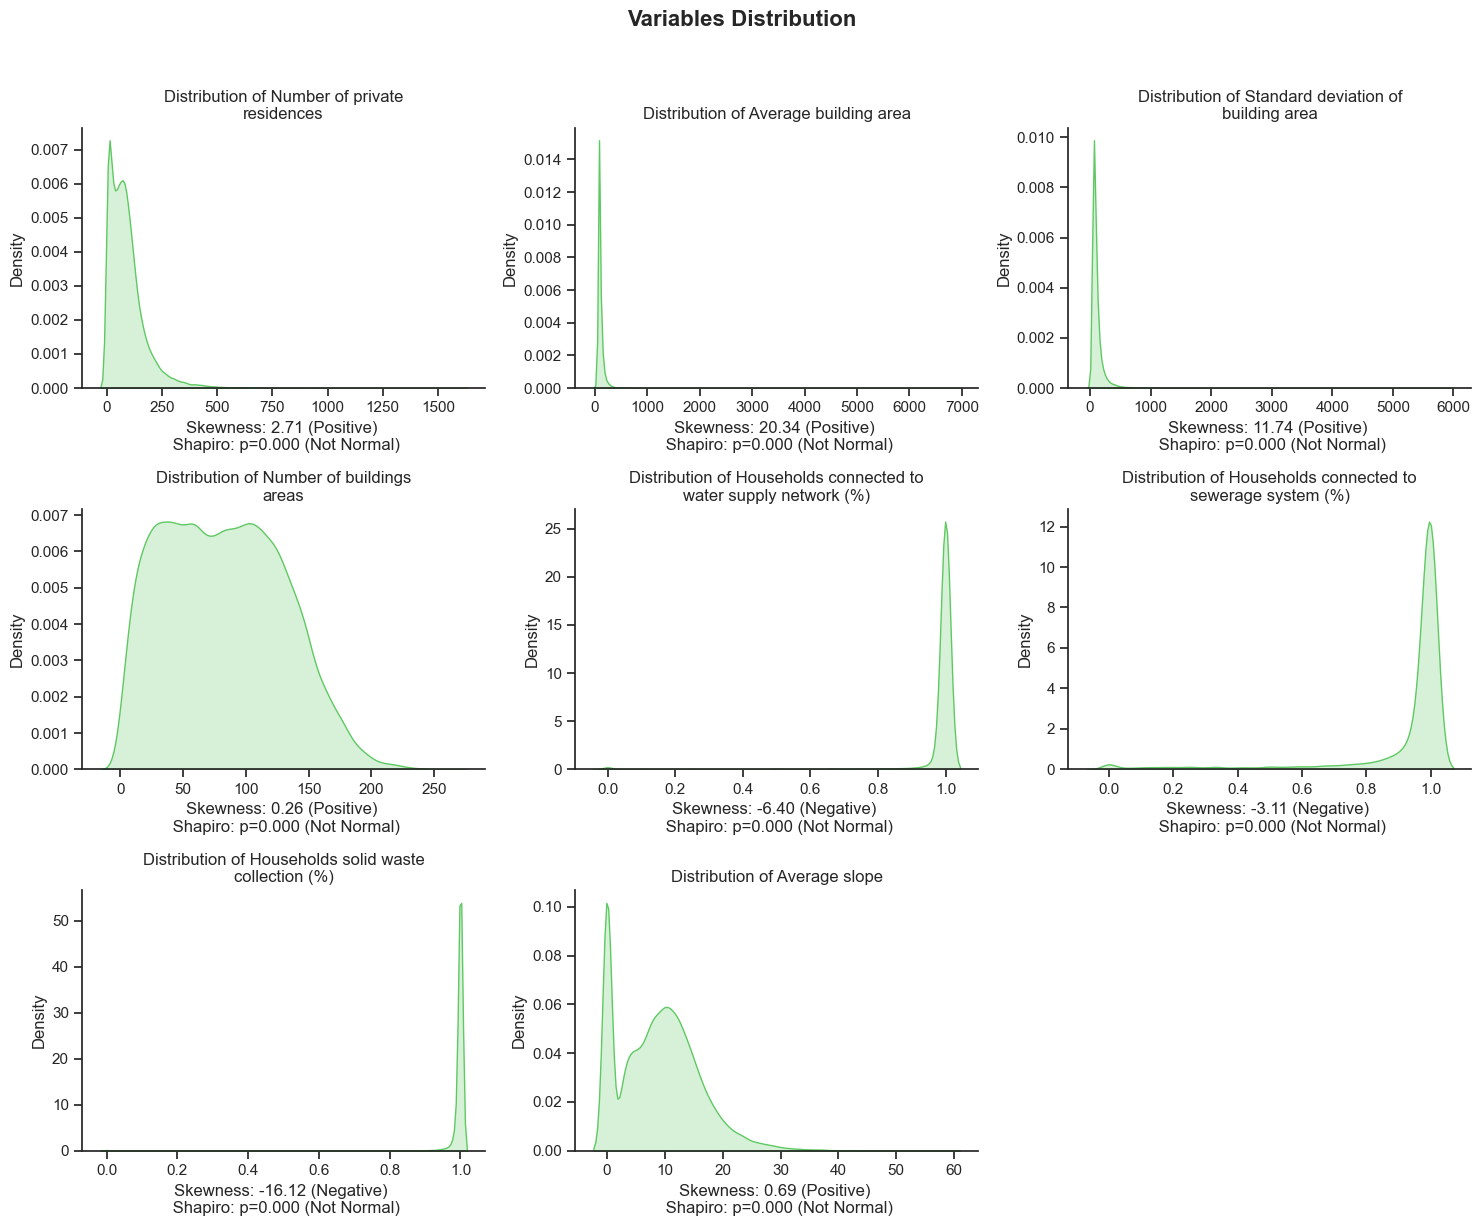

In [249]:
plot_distributions_and_tests(df_filtered.drop('is_fcu', axis=1))

### Analise das Distribuições 
- Nenhum dado é normal 
- Todos tem Skewness positivo -> utilizar Spearman's rank correlation
- Tem uma grande concentração com Zeros, não tem como aplicar log para normalizar

# Analise das variaveis binarias

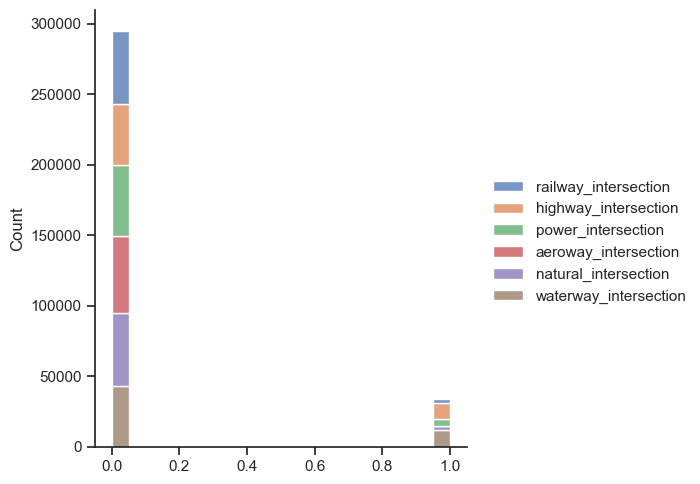

In [251]:
sns.displot(dados_f[binary_var],multiple="stack")

## Correlação

In [207]:
# Função para calcular a correlação e criar o gráfico
def plot_correlation(df, method="pearson"):
    # Calcular a correlação de Spearman
    corr_matrix = df.corr(method=method)

    # Criar uma máscara para a parte superior da matriz
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Criar um mapa de cores para o gráfico
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Configurar a figura
    plt.figure(figsize=(10, 8))

    # Plotar o mapa de calor da correlação com Seaborn
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})

    # Adicionar título
    plt.title(f"{method}'s Correlation", fontsize=16, weight='bold')
    
    # Mostrar o gráfico
    plt.show()

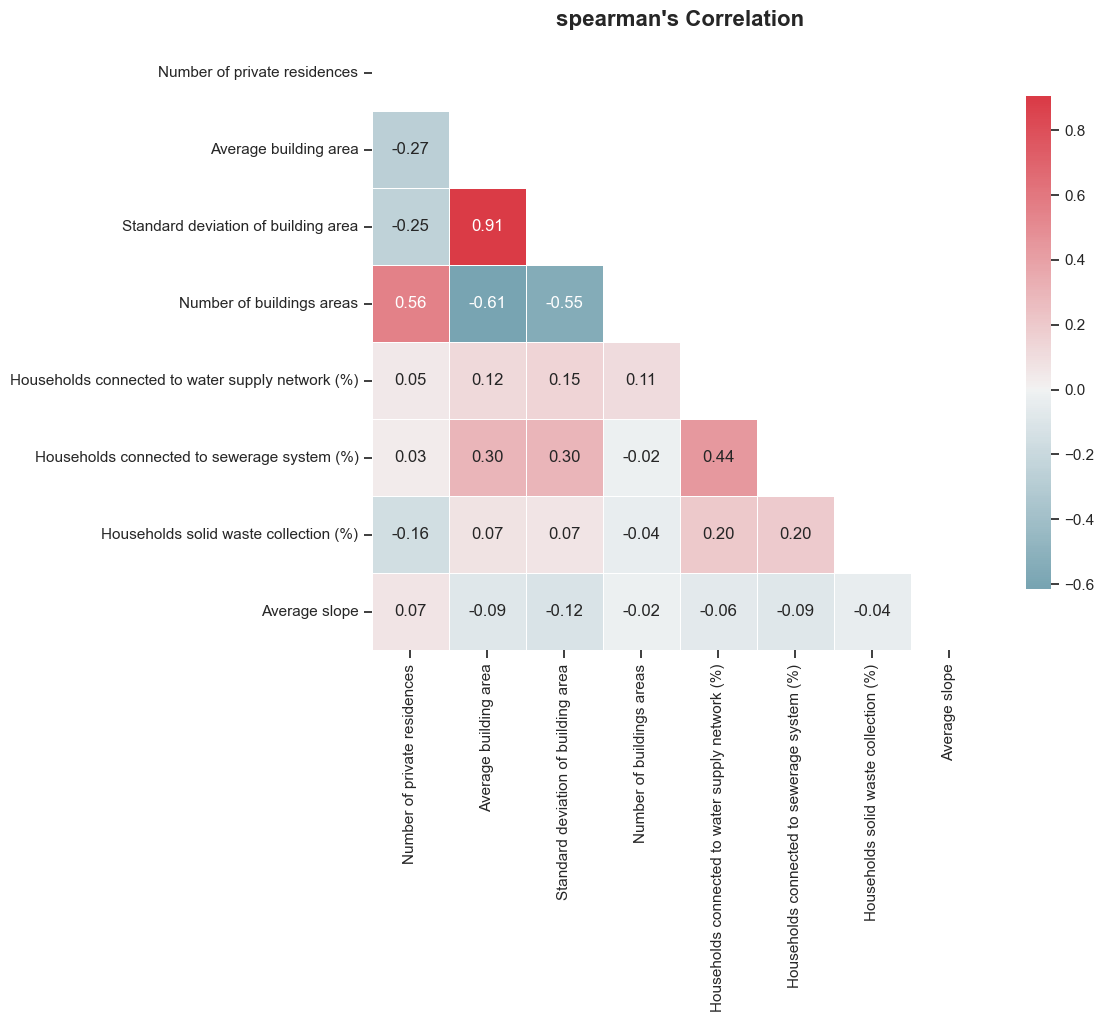

In [250]:
plot_correlation(df_filtered.drop('is_fcu', axis=1), 'spearman')

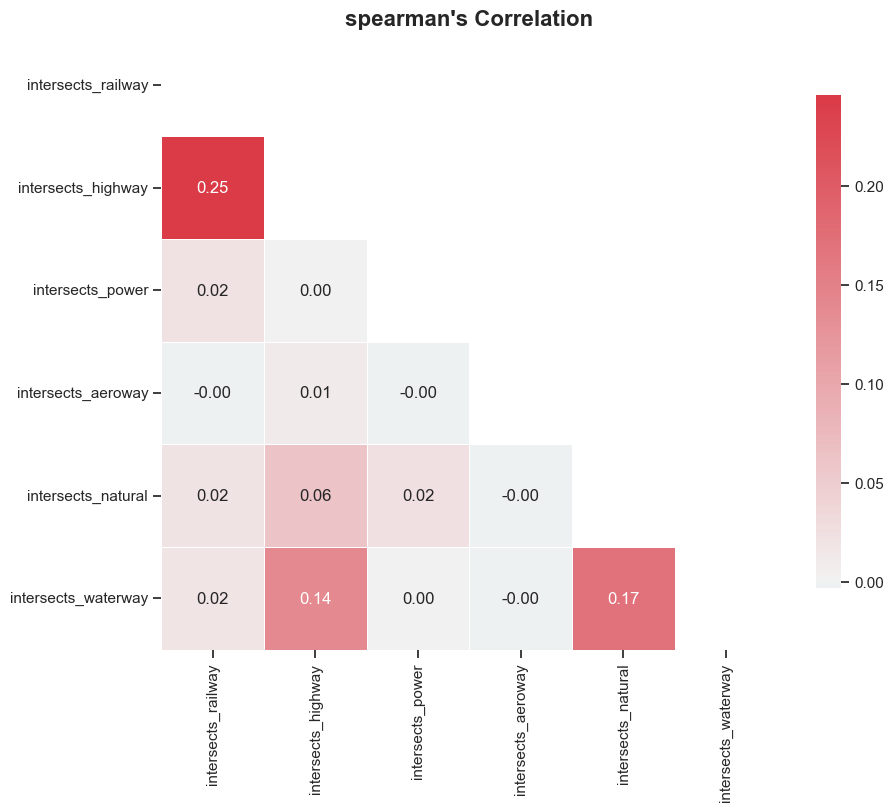

In [209]:
plot_correlation(dados_f[binary_var], 'spearman')

In [210]:
from scipy.stats import pointbiserialr

# Example DataFrame 'hex_sp' containing both dichotomous and continuous columns
# Select dichotomous (binary) columns
dichotomous_cols = [
    'intersects_railway', 'intersects_highway', 'intersects_power',
    'intersects_aeroway', 'intersects_natural', 'intersects_waterway'
]

# Select continuous columns
continuous_cols = [
    'qnt_unidades_residencias_sum', 'esp_1', 'area_mean', 'area_std', 'area_count',
    'D1_012_p', 'D1_017_p', 'D1_035_p', 'D1_044_p'
]

# Create an empty DataFrame to store results
correlation_results = []
# Loop through each pair of dichotomous and continuous variables
for dichotomous_col in binary_var:
    for continuous_col in variables.keys():
        # Calculate point-biserial correlation
        correlation, p_value = pointbiserialr(dados[dichotomous_col], dados[continuous_col])
        
        # Append the results
        correlation_results.append({
            "Dichotomous_Variable": dichotomous_col,
            "Continuous_Variable": continuous_col,
            "Correlation": correlation,
            "p-value": p_value
        })

correlation_results = pd.DataFrame(correlation_results, columns=["Dichotomous_Variable", "Continuous_Variable", "Correlation", "p-value"])
# Display the results sorted by correlation strength
correlation_results.sort_values(by="Correlation", ascending=False, inplace=True)
print(correlation_results)

   Dichotomous_Variable                      Continuous_Variable  Correlation  \
11   intersects_highway                                area_mean     0.153164   
12   intersects_highway                                 area_std     0.149099   
15   intersects_highway  domicilios_esgoto_rede_geral_porcentage     0.109897   
2    intersects_railway                                area_mean     0.108213   
3    intersects_railway                                 area_std     0.099309   
14   intersects_highway    domicilios_agua_rede_geral_porcentage     0.062073   
0    intersects_railway             qnt_unidades_residencias_sum     0.058428   
6    intersects_railway  domicilios_esgoto_rede_geral_porcentage     0.051321   
30   intersects_aeroway                                 area_std     0.033537   
29   intersects_aeroway                                area_mean     0.033226   
38   intersects_natural                                area_mean     0.031756   
39   intersects_natural     

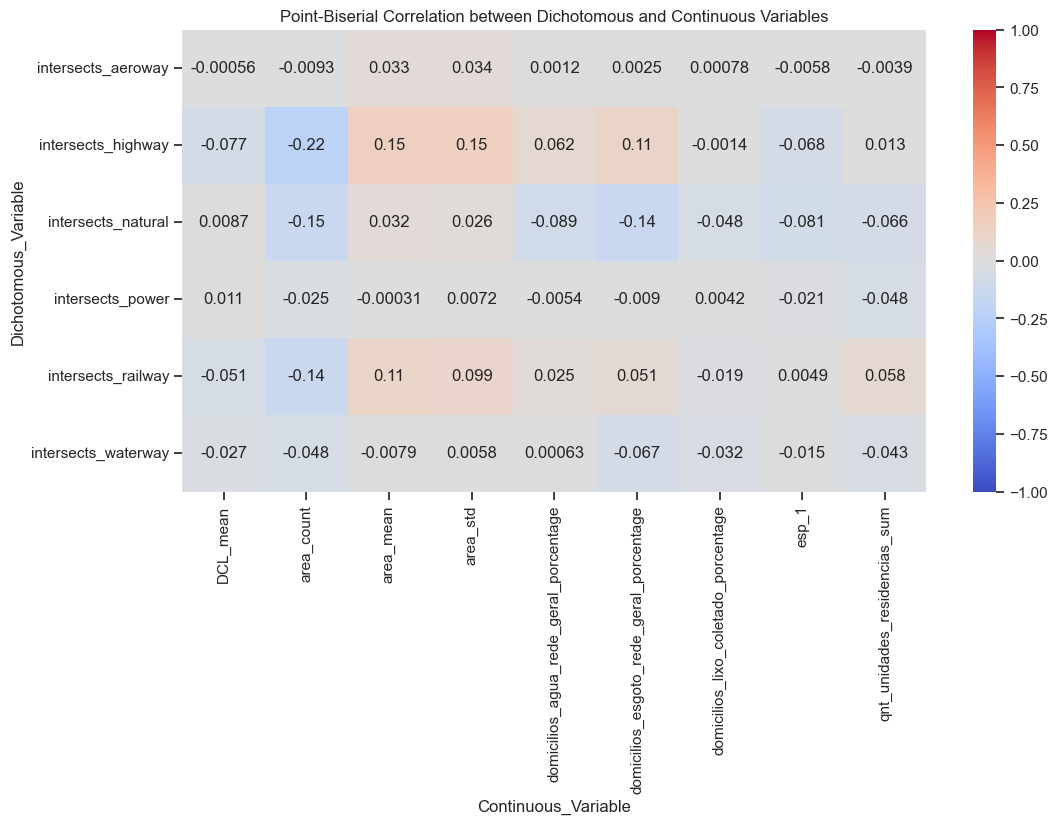

In [211]:

# Pivot the correlation data for heatmap format
heatmap_data = correlation_results.pivot_table(index="Dichotomous_Variable", columns="Continuous_Variable", values="Correlation")

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Point-Biserial Correlation between Dichotomous and Continuous Variables")
plt.show()

# Testes de Hipoteses


/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32207.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32207.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32207.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32207.
  res = hypotest_fun_out(*samples, **kw

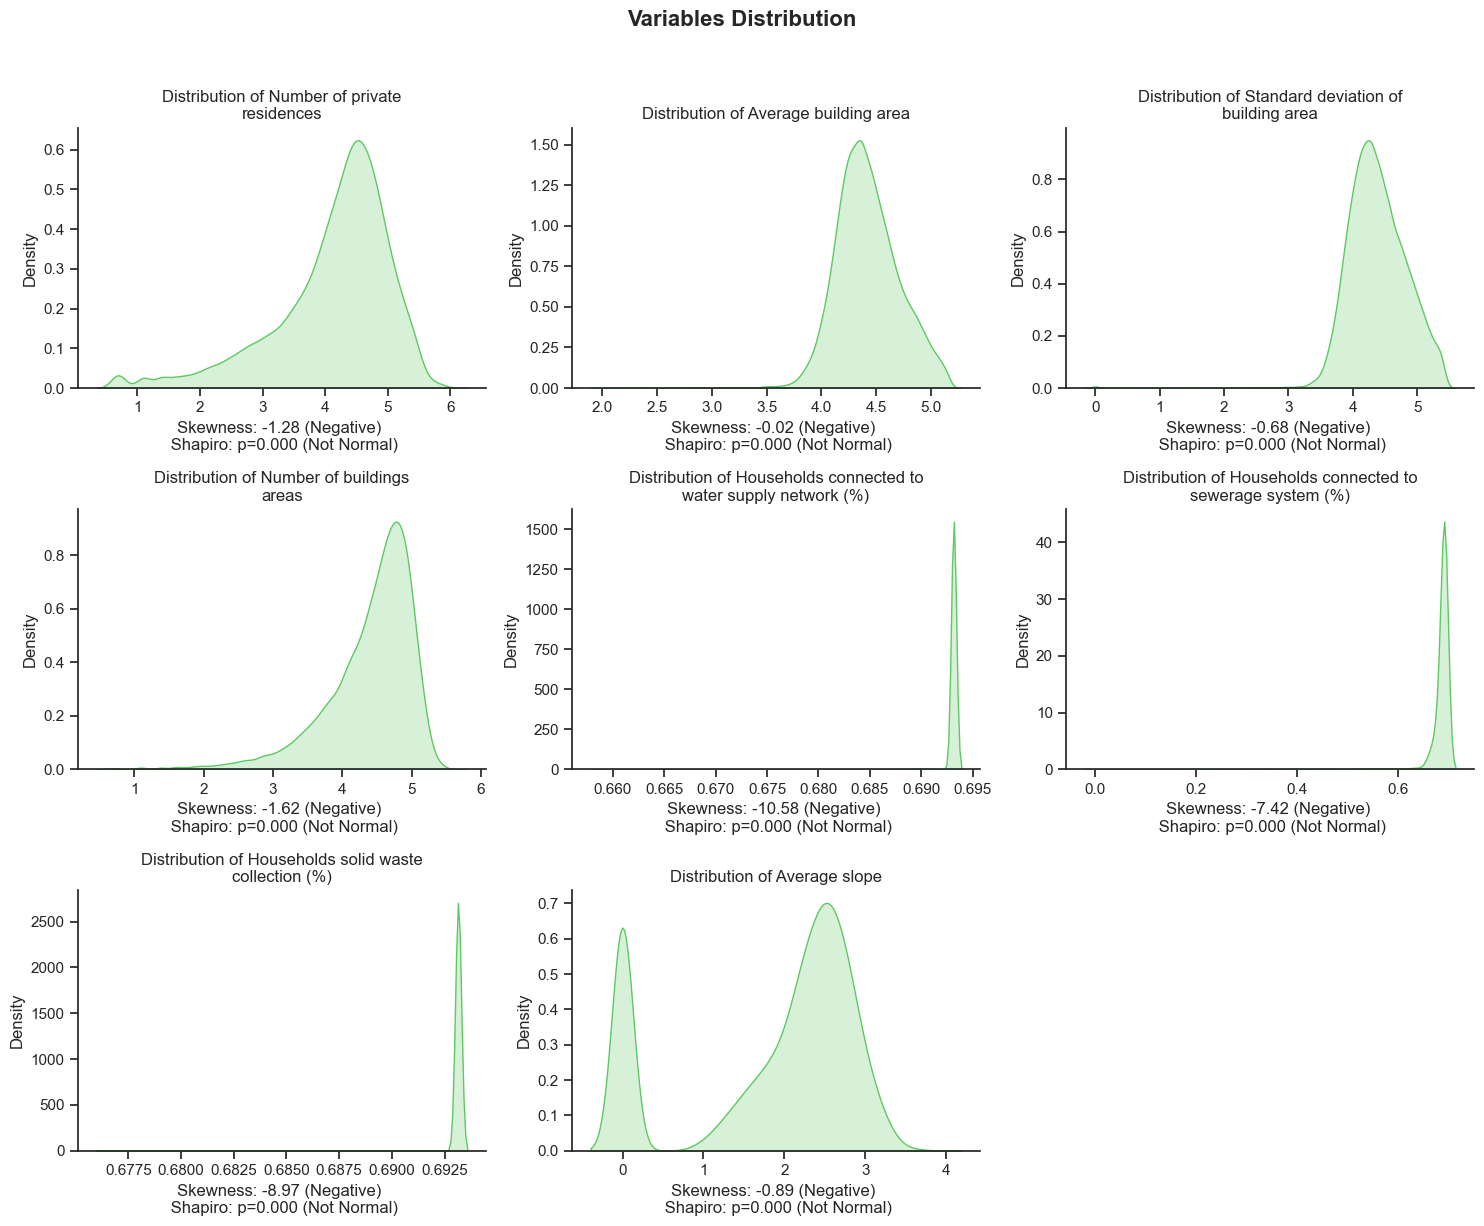

In [252]:
# apply a log(x) + 1 for the dataset and use the plot_distributions_and_tests function to visualiza the results
df_filtered_log = np.log(df_filtered_no_outliers.drop('is_fcu', axis=1) + 1)  

plot_distributions_and_tests(df_filtered_log)
df_filtered_log['is_fcu'] = df_filtered['is_fcu']



In [254]:
from scipy.stats import ttest_ind

# Function to perform t-test for each variable and include mean and std of each class
def perform_t_tests(df, target_col):
    results = []
    for col in df.columns:
        if col != target_col:
            class_0 = df[df[target_col] == 0][col]
            class_1 = df[df[target_col] == 1][col]
            t_stat, p_value = ttest_ind(class_0, class_1, nan_policy='omit')
            results.append({
                'Variable': col,
                'Class 0 Mean': class_0.mean(),
                'Class 0 Std': class_0.std(),
                'Class 1 Mean': class_1.mean(),
                'Class 1 Std': class_1.std(),
                'T-Statistic': t_stat,
                'P-Value': p_value
            })
    return pd.DataFrame(results)

# Perform t-tests
t_test_results = perform_t_tests(df_filtered_no_outliers, 'is_fcu')

# Check hypothesis with 90% probability
alpha = 0.10
t_test_results['Reject H0'] = t_test_results['P-Value'] < alpha

print(t_test_results)


                                           Variable  Class 0 Mean  \
0                      Number of private residences     77.619415   
1                             Average building area     87.460877   
2               Standard deviation of building area     89.869809   
3                         Number of buildings areas     90.254741   
4  Households connected to water supply network (%)      1.000000   
5       Households connected to sewerage system (%)      0.992431   
6             Households solid waste collection (%)      1.000000   
7                                     Average slope      8.324854   

   Class 0 Std  Class 1 Mean  Class 1 Std  T-Statistic       P-Value  \
0    50.574360    141.788493    79.262582   -56.951574  0.000000e+00   
1    25.154311     60.202115    11.041360    52.853097  0.000000e+00   
2    39.665216     49.176201    13.034682    50.207190  0.000000e+00   
3    41.538042    129.068709    47.689717   -43.655450  0.000000e+00   
4     0.000000    

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


# Salvar Dados Filtrados

In [256]:
dados.loc[df_filtered.index].to_file('data/generated/WGS84_hex_agg_sp_filtred.gpkg', driver="GPKG")